<a href="https://colab.research.google.com/github/Phantom1746a/HumanActionRecoginationUsingConvLSTM.ipynb/blob/main/HumanActionRecoginationUsingLSTM%26CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 # instaling PAFY

 !pip install pafy youtube-dl moviepy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.6 MB/s eta 0:00:00


##Importing Libraries and Tensorflow Layers


In [ ]:
#imprting libraries
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline
#importing Train-Test split
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model




In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

#Downloading Dataset

In [ ]:
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101.rar
!unrar x UCF101.rar

Streaming output truncated to the last 5000 lines.
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g06_c05.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g06_c06.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g06_c07.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c01.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c02.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c03.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c04.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c05.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c06.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c07.avi             62%  OK 
Extracting  UCF-101/PlayingGu

In [ ]:
all_class = os.listdir('UCF-101')
print(all_class)

['HighJump', 'PlayingPiano', 'FrontCrawl', 'PizzaTossing', 'BandMarching', 'UnevenBars', 'BoxingSpeedBag', 'HandstandPushups', 'Drumming', 'CuttingInKitchen', 'TrampolineJumping', 'ApplyEyeMakeup', 'JumpRope', 'PlayingDhol', 'Hammering', 'BlowingCandles', 'BenchPress', 'Basketball', 'BaseballPitch', 'CliffDiving', 'GolfSwing', 'BoxingPunchingBag', 'Nunchucks', 'Skijet', 'Bowling', 'Diving', 'BodyWeightSquats', 'RockClimbingIndoor', 'Fencing', 'TennisSwing', 'WritingOnBoard', 'PommelHorse', 'PoleVault', 'CricketBowling', 'HeadMassage', 'HorseRace', 'WallPushups', 'TableTennisShot', 'Rafting', 'JugglingBalls', 'Swing', 'SumoWrestling', 'PlayingDaf', 'SkyDiving', 'PlayingTabla', 'FrisbeeCatch', 'StillRings', 'BalanceBeam', 'FloorGymnastics', 'SalsaSpin', 'HulaHoop', 'RopeClimbing', 'PlayingCello', 'Typing', 'VolleyballSpiking', 'MoppingFloor', 'PullUps', 'Punch', 'PushUps', 'BasketballDunk', 'IceDancing', 'Mixing', 'BabyCrawling', 'BreastStroke', 'CleanAndJerk', 'CricketShot', 'Surfing', 

#Displaying Random Video Frames from UCF-101
This code generates a grid of 20 randomly selected video frames from the UCF-101 dataset, each with the corresponding class label overlaid. It uses OpenCV to read and process the video frames and Matplotlib to display the grid.

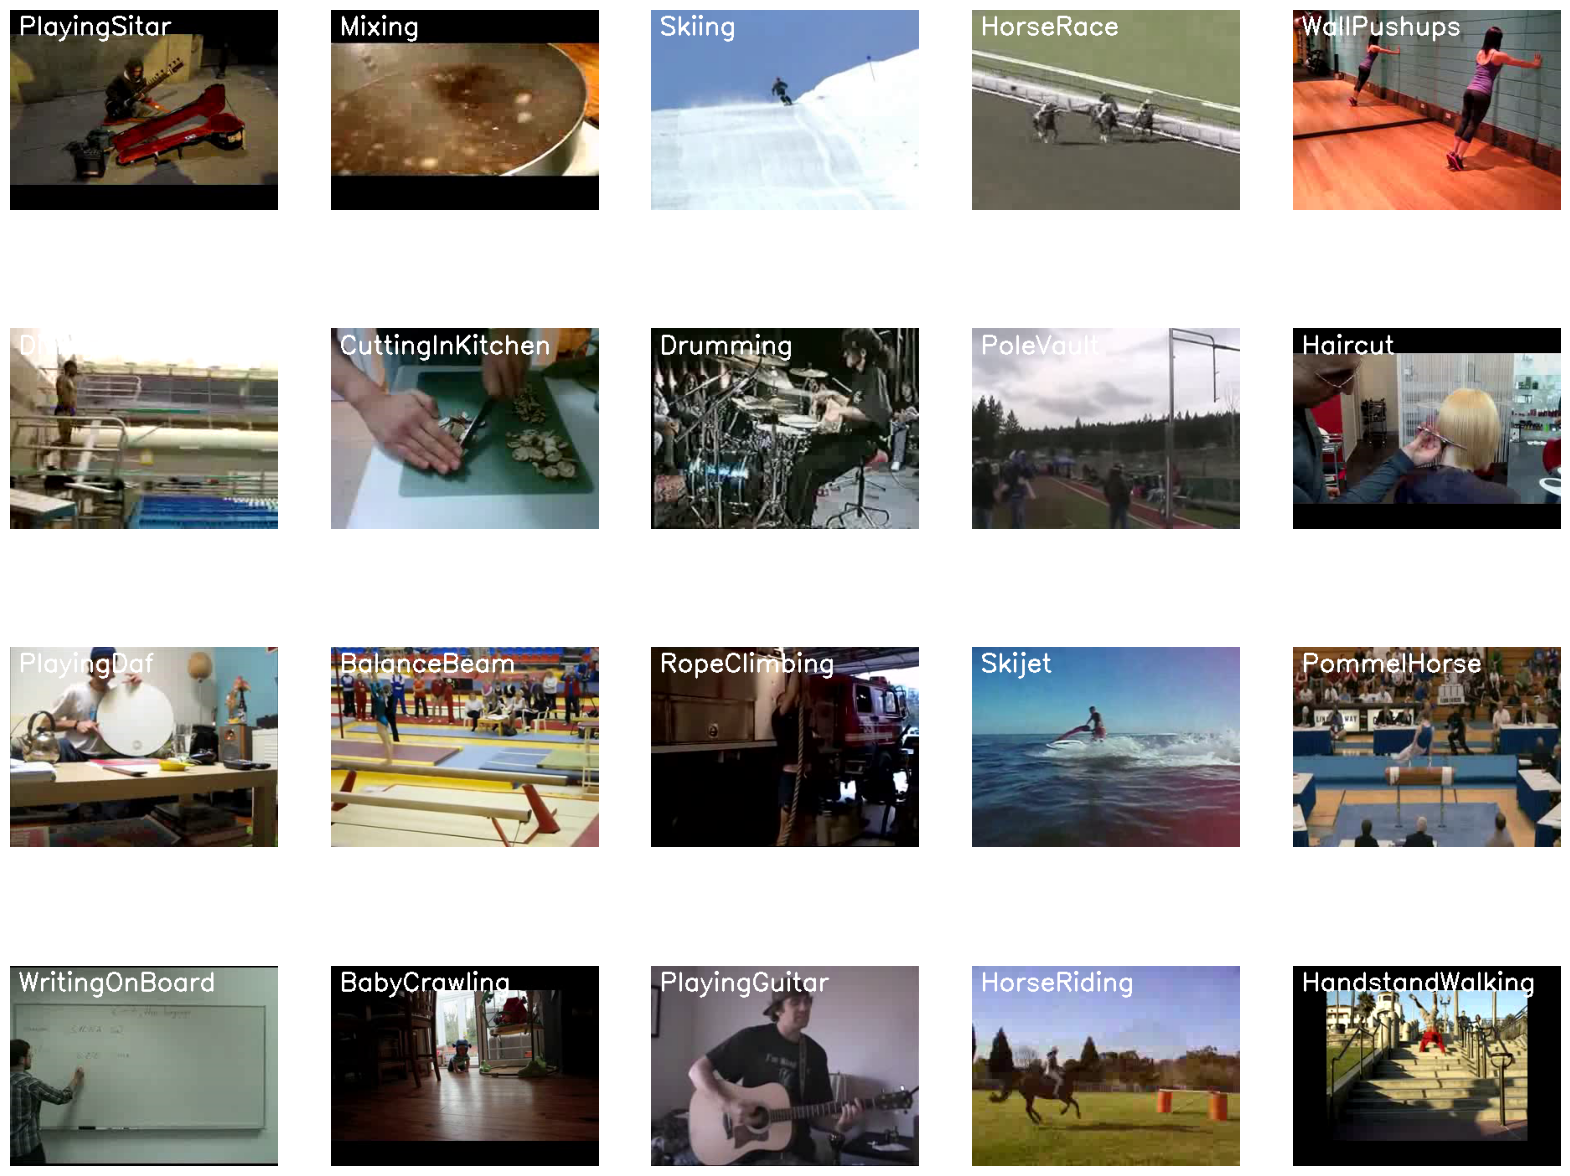

In [ ]:
plt.figure(figsize = (20,20))

random_range = random.sample(range(len(all_class)),20)

for counter, random_index in enumerate(random_range,1):
  selected_class_Name= all_class[random_index]
  video_files_name_list = os.listdir(f'UCF-101/{selected_class_Name}')
  selected_video_file_name = random.choice(video_files_name_list)
  video_reader = cv2.VideoCapture(f'UCF-101/{selected_class_Name}/{selected_video_file_name}')
  _, bgr_frame = video_reader.read()
  video_reader.release
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

  cv2.putText(rgb_frame, selected_class_Name, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 2)
  plt.subplot(5,5,counter)
  plt.imshow(rgb_frame)
  plt.axis('off')


#Preprocessing the data

In [ ]:
IMAGE_HEIGHT, IMAGE_LENGHT= 64,64

Sequence_Length = 20
Dataset_Directory = 'UCF-101'
#Classes_List=all_class
Classes_List=['WalkingWithDog','TaiChi','Swing','PlayingCello','HorseRace','WritingOnBoard']

In [ ]:
print(Classes_List)

['WalkingWithDog', 'TaiChi', 'Swing', 'PlayingCello', 'HorseRace', 'WritingOnBoard']


#Creating a function to Extract rezise and normalize frames


In [ ]:
def frames_extraction(video_path):
    '''
    This function will extract frames from a video and return the path to the frame
    '''
    # Empty List declared to store video frames
    frames_list = []
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)
    #get total number of frames in video
    video_frame_count= int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    #get the fps
    #video_fps= int(video_reader.get(cv2.CAP_PROP_FPS))
    #calculate the intervel after which frame will be added to list
    skip_frames_window = max(int(video_frame_count/Sequence_Length), 1)
    # iterate through the video frames
    for frame_counter in range(Sequence_Length):
      #set current frame position of video
      video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
      #reading the frame from video
      success, frame = video_reader.read()
      #Check if video frame is not read and break loop
      if not success:
          break
      # resize the frame to fixed hieght and width.
      resized_frame = cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_LENGHT))
      #normalize the frame between 0 to 1 by dividing by 255
      normalized_frame=resized_frame/255
      #Append the frames to list
      frames_list.append(normalized_frame)

    video_reader.release()

    return frames_list

#Create a function for dataset collection

In [ ]:
def create_dataset():
  features=[]
  labels=[]
  video_file_paths=[]

  for class_index, class_name in enumerate(Classes_List):
    print(f'Extracting Data of Class: {class_name}')
    files_list=os.listdir(os.path.join(Dataset_Directory, class_name))
    for file_name in files_list:
      video_file_path=os.path.join(Dataset_Directory, class_name, file_name)
      frames=frames_extraction(video_file_path)
      if len(frames)==Sequence_Length:
        features.append(frames)
        labels.append(class_index)
        video_file_paths.append(video_file_path)

  features=np.array(features)
  labels=np.array(labels)

  return features, labels, video_file_paths

#CREATE DATASET

In [ ]:
features, labels, video_file_paths=create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: PlayingCello
Extracting Data of Class: HorseRace
Extracting Data of Class: WritingOnBoard


In [ ]:
#one hot encoding
one_hot_encoded_labels=to_categorical(labels)

#Train Test split

In [ ]:
X_train, X_test , y_train, y_test = train_test_split(features,one_hot_encoded_labels, test_size=0.25, random_state=seed_constant,shuffle=True)

#Create ConvLSTM model

In [ ]:
def create_convlstm_model():
    model = Sequential()
    model.add(ConvLSTM2D(filters=4,kernel_size=(3,3), activation='tanh',data_format='channels_last', recurrent_dropout=0.2, return_sequences=True, input_shape=(Sequence_Length, IMAGE_HEIGHT, IMAGE_LENGHT, 3)))
    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same',data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    model.add(ConvLSTM2D(filters=8,kernel_size=(3,3), activation='tanh',data_format='channels_last', recurrent_dropout=0.2, return_sequences=True, ))
    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same',data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    model.add(ConvLSTM2D(filters=14,kernel_size=(3,3), activation='tanh',data_format='channels_last', recurrent_dropout=0.2, return_sequences=True, ))
    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same',data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    model.add(ConvLSTM2D(filters=16,kernel_size=(3,3), activation='tanh',data_format='channels_last', recurrent_dropout=0.2, return_sequences=True, ))
    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same',data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    model.add(Flatten())
    model.add(Dense(len(Classes_List), activation='softmax'))
    model.summary()
    return model


  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)             │ (None, 20, 62, 62, 4)       │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)           │ (None, 20, 29, 29, 8)       │           3,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)           │ (None, 20, 13, 13, 14)      │          11,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)           │ (None, 20, 5, 5, 16)        │          17,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 20, 3, 3, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2880)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │          17,286 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,286 (196.43 KB)

 Trainable params: 50,286 (196.43 KB)

 Non-trainable params: 0 (0.00 B)

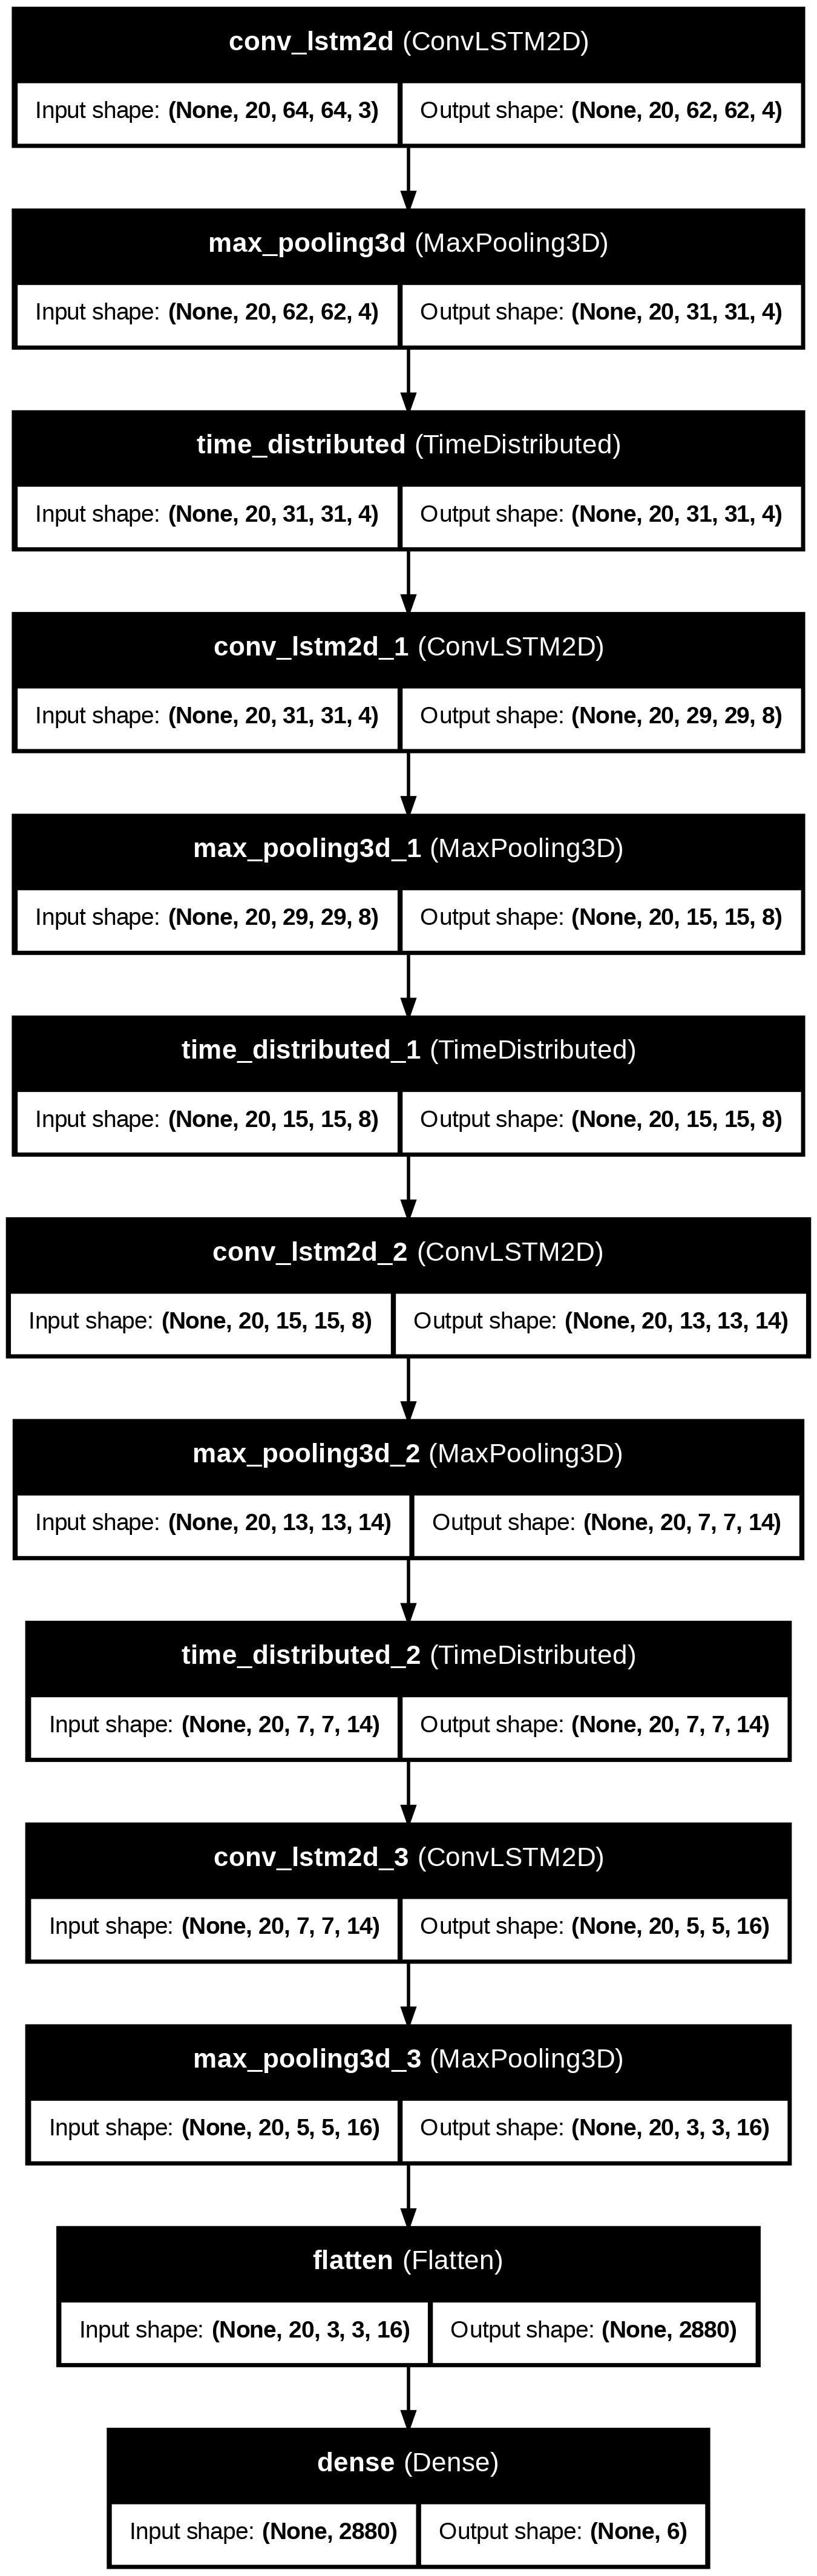

In [ ]:
plot_model(create_convlstm_model(), to_file='convlstm_model_structure_plot.png', show_shapes=True, show_layer_names=True)

#Compile and train the model

In [ ]:
convlstm_model=create_convlstm_model()
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=10,mode='min,restore_best_weights=True')
convlstm_model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
convlstm_model_training_history=convlstm_model.fit(X_train,y_train,epochs=50,batch_size=4,shuffle=True,validation_split=0.2,callbacks=[early_stopping_callback])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d_4 (ConvLSTM2D)           │ (None, 20, 62, 62, 4)       │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_4 (MaxPooling3D)       │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_5 (ConvLSTM2D)           │ (None, 20, 29, 29, 8)       │           3,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_5 (MaxPooling3D)       │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_6 (ConvLSTM2D)           │ (None, 20, 13, 13, 14)      │          11,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_6 (MaxPooling3D)       │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_7 (ConvLSTM2D)           │ (None, 20, 5, 5, 16)        │          17,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_7 (MaxPooling3D)       │ (None, 20, 3, 3, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2880)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │          17,286 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,286 (196.43 KB)

 Trainable params: 50,286 (196.43 KB)

 Non-trainable params: 0 (0.00 B)

  early_stopping_callback=EarlyStopping(monitor='val_loss',patience=10,mode='min,restore_best_weights=True')



Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 75s 92ms/step - accuracy: 0.3308 - loss: 1.6895 - val_accuracy: 0.4454 - val_loss: 1.3498
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.5826 - loss: 1.1087 - val_accuracy: 0.6050 - val_loss: 0.9965
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.6787 - loss: 0.8641 - val_accuracy: 0.6555 - val_loss: 0.9573
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.6988 - loss: 0.8046 - val_accuracy: 0.6134 - val_loss: 0.9100
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.7584 - loss: 0.7002 - val_accuracy: 0.7143 - val_loss: 0.8533
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8319 - loss: 0.4541 - val_accuracy: 0.7899 - val_loss: 0.6912
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.8923 - loss: 0.3156 - val_accuracy: 0.7899 - val_loss: 0.6338
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9372 - loss: 0.2010 - val

In [ ]:
!pip install seaborn
import seaborn as sns

#Plot traing and validation accuracy and loss

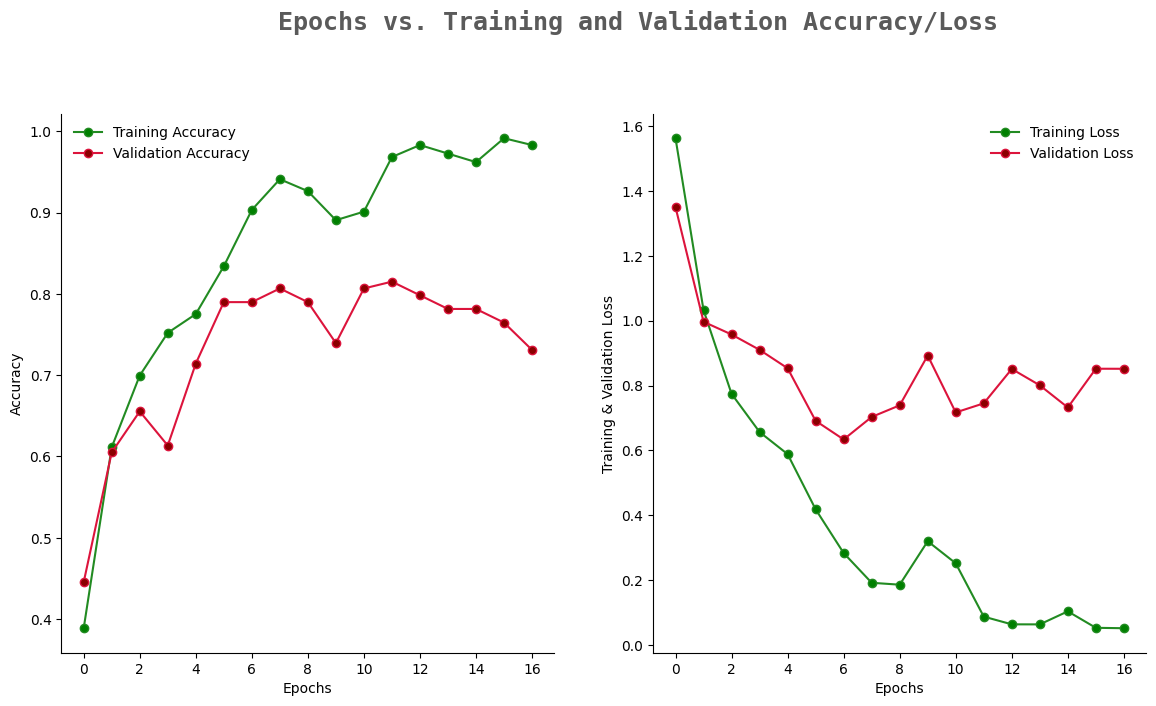

In [ ]:
epochs = [i for i in range(len(convlstm_model_training_history.history['accuracy']))] # Create epochs list based on length of training history
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_green = ["#00FF00", "#32CD32", '#008000', '#228B22', '#006400']
colors_red = ["#FF0000", "#B22222", '#8B0000', '#DC143C', '#FF6347']
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = convlstm_model_training_history.history['accuracy']
train_loss = convlstm_model_training_history.history['loss']
val_acc = convlstm_model_training_history.history['val_accuracy']
val_loss =convlstm_model_training_history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
model_evalution_history=convlstm_model.evaluate(X_test,y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 385ms/step - accuracy: 0.8416 - loss: 0.6021
